In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

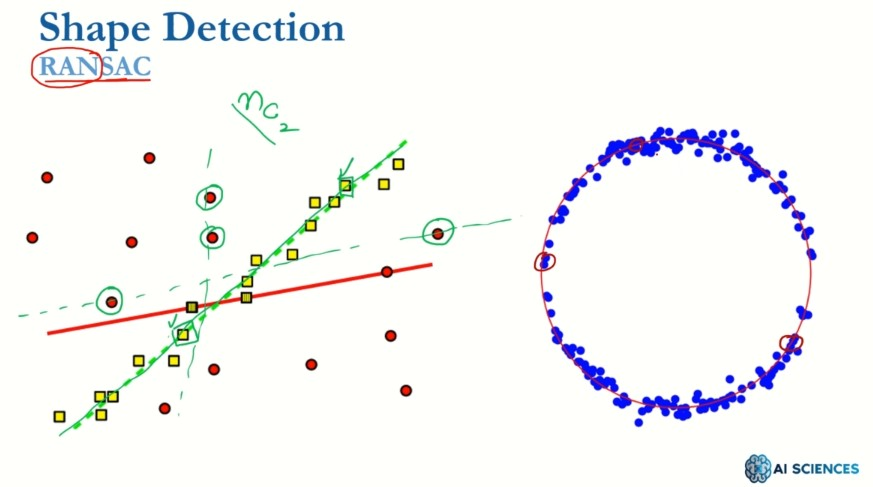

In [1]:
from IPython.display import Image
Image("Screenshot.jpg")

In [ ]:
"take t2o random points and draw a line between them"
" get the highest line in number of points on it"

In [3]:
def f_randomSample(r,c,n):
    """
    r: rows
    c: columns
    n: number of points
    """
    totalPoints = len(r)
    idx = np.random.permutation(np.arange(totalPoints))
    idx = idx[:n]
    r2,c2 = [],[]
    for i in range(len(idx)):
        # row coordinate
        # X
        r2.append(r[idx[i]])
        # column coordinate
        # Y
        c2.append(c[idx[i]])
    return r2,c2
    

In [4]:
r = np.arange(10)
c = np.arange(10)[::-1]
r2,c2 = f_randomSample(r,c,2)
print(r2,c2)

[4, 0] [5, 9]


In [5]:
r

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [6]:
c

array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])

In [7]:
def f_fitLine(r1,c1,r2,c2):
    """
    r1: row coordinate of first point
    c1: column coordinate of first point
    r2: row coordinate of second point
    c2: column coordinate of second point
    """
    # get the slope -> a
    # get the intercept -> b

    p = np.array([1,1])
    A = np.array([[r1,1],[r2,1]])
    q = np.array([[c1],[c2]])
    if np.linalg.matrix_rank(A) == 2:
        p = np.linalg.inv(A).dot(q)
    a , b = p[0] , p[1]
    return a,b

In [8]:
r = np.arange(10)
c = np.arange(10)[::-1]
r2,c2 = f_randomSample(r,c,2)
a,b = f_fitLine(r2[0],c2[0],r2[1],c2[1])

In [9]:
a,b

(array([-1.]), array([9.]))

In [10]:
c2

[9, 7]

In [11]:
def f_getConsistencyScore(r,c,th,a,b):
    # best line fit
    score = 0
    for i in range(len(r)):
        squaredError = (a*r[i]+b - c[i])**2
        if squaredError < th:
            score += 1
    return score

In [12]:
def f_RANSACLine(E):
    """
    E: image
    """
    E = E>0
    idx = np.argwhere(E)
    r , c = idx[:,0] , idx[:,1]
    best_a , best_b = 0 , 0
    maxScore = -1
    numIter = 5
    for iter in range(numIter):
        r2,c2 = f_randomSample(r,c,2)
        a,b = f_fitLine(r2[0],c2[0],r2[1],c2[1])
        score = f_getConsistencyScore(r,c,2,a,b)
        if score > maxScore:
            maxScore = score
            best_a , best_b = a,b
    return best_a,best_b
    

In [15]:
E = plt.imread(r'./images/E.png')

In [16]:
E = E[:,:,0]

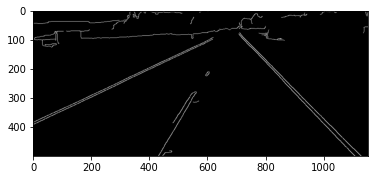

In [17]:
plt.imshow(E,cmap='gray')

In [123]:
E.max() , E.min()

(1.0, 0.0)

In [124]:
E.dtype

dtype('float32')

In [18]:
best_a, best_b = f_RANSACLine(E)
best_a, best_b

(array([-2.15241636]), array([821.46840149]))

In [126]:
def f_getExtents(a,b,numRows,numCols):
    """
    draw line in image
    a: slope
    b: intercept
    numRows: number of rows
    numCols: number of columns
    """
    # get the extents of the line
    # get the leftmost point
    # get the rightmost point
    # get the topmost point
    # get the bottommost point

    r1 = int(0)
    c1 = int(a*r1+b)
    r2 = int(numRows-1)
    c2 = int(a*r2+b)
    return (c1,r1),(c2,r2)

In [127]:
s,e = f_getExtents(best_a,best_b,E.shape[0],E.shape[1])

In [128]:
s,e

((634, 0), (443, 498))

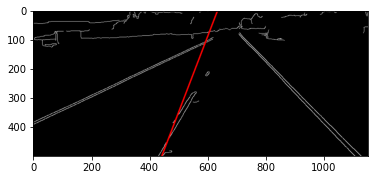

In [129]:
E2 = np.zeros((E.shape[0],E.shape[1],3),dtype=np.uint8)
# * what has value 1 make it 255
E3 = np.array(255*E,dtype = np.uint8)
E2[:,:,0] = E3
E2[:,:,1] = E3
E2[:,:,2] = E3
I = cv2.line(E2,s,e,(0,0,255),3)
plt.imshow(I[:,:,::-1])

In [19]:
def f_fitCircle(x1,y1,x2,y2,x3,y3):
    c = (x1-x2)**2 + (y1-y2)**2
    a = (x2-x3)**2 + (y2-y3)**2
    b = (x3-x1)**2 + (y3-y1)**2
    s = 2*(a*b + b*c + c*a) - (a*a + b*b + c*c) 
    px = (a*(b+c-a)*x1 + b*(c+a-b)*x2 + c*(a+b-c)*x3) / s
    py = (a*(b+c-a)*y1 + b*(c+a-b)*y2 + c*(a+b-c)*y3) / s 
    ar = a**0.5
    br = b**0.5
    cr = c**0.5 
    r = ar*br*cr / ((ar+br+cr)*(-ar+br+cr)*(ar-br+cr)*(ar+br-cr))**0.5
    return px,py,r

In [20]:
def f_getConsistencyScore_circle(r,c,th,cr,cc,d):
    score = 0
    for i in range(len(r)):
        sd = ((r[i]-cr)**2 + (c[i]-cc)**2 - d**2)**2
        if sd < th:
            score += 1
    return score

In [21]:
def f_RANSACCircle(E):
    E = E>0
    idx = np.argwhere(E)
    r , c = idx[:,0] , idx[:,1]
    best_cr , best_cc , best_d = 0 , 0 , 0
    maxScore = -1
    numIter = 2000
    for iter in range(numIter):
        r2,c2 = f_randomSample(r,c,3)
        cr,cc,d = f_fitCircle(r2[0],c2[0],r2[1],c2[1],r2[2],c2[2])
        score = f_getConsistencyScore_circle(r,c,3,cr,cc,d)
        if score > maxScore:
            maxScore = score
            best_cr , best_cc , best_d = cr , cc , d
    return best_cr , best_cc , best_d

In [22]:
E = cv2.imread(r'.\images\Ec.png',cv2.IMREAD_GRAYSCALE)

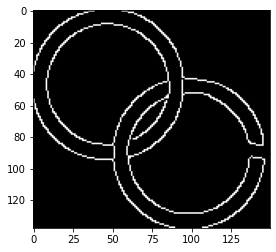

In [23]:
plt.imshow(E,cmap='gray')

In [24]:
E.shape

(138, 150)

In [25]:
E.max(),E.min()

(255, 0)

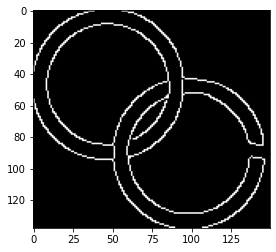

In [26]:
E = E>100
plt.imshow(E,cmap='gray')

In [27]:
best_cr,best_cc,best_d = f_RANSACCircle(E)

In [28]:
best_cr,best_cc,best_d

(90.5, 98.5, 47.56574397610112)

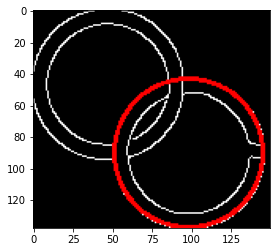

In [29]:
E2 = np.zeros((E.shape[0],E.shape[1],3),dtype=np.uint8)
E3 = np.array(255*E,dtype = np.uint8)
E2[:,:,0] = E3
E2[:,:,1] = E3
E2[:,:,2] = E3
I = cv2.circle(E2,(int(best_cc),int(best_cr)),int(best_d),(0,0,255),2)
plt.imshow(I[:,:,::-1])

C:\Users\oeb\AppData\Local\Temp/ipykernel_14692/542909876.py:6: RuntimeWarning: invalid value encountered in longlong_scalars
  px = (a*(b+c-a)*x1 + b*(c+a-b)*x2 + c*(a+b-c)*x3) / s
C:\Users\oeb\AppData\Local\Temp/ipykernel_14692/542909876.py:7: RuntimeWarning: invalid value encountered in longlong_scalars
  py = (a*(b+c-a)*y1 + b*(c+a-b)*y2 + c*(a+b-c)*y3) / s
C:\Users\oeb\AppData\Local\Temp/ipykernel_14692/542909876.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  r = ar*br*cr / ((ar+br+cr)*(-ar+br+cr)*(ar-br+cr)*(ar+br-cr))**0.5


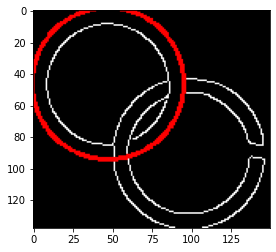

In [30]:
best_cr,best_cc,best_d = f_RANSACCircle(E)
E2 = np.zeros((E.shape[0],E.shape[1],3),dtype=np.uint8)
E3 = np.array(255*E,dtype = np.uint8)
E2[:,:,0] = E3
E2[:,:,1] = E3
E2[:,:,2] = E3
I = cv2.circle(E2,(int(best_cc),int(best_cr)),int(best_d),(0,0,255),2)
plt.imshow(I[:,:,::-1])

**Very random shit algorithm**